<a href="https://colab.research.google.com/github/pvtien96/quantization/blob/main/notebooks/Change_Point_Guided_Pruning_Configuration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Section A: Problem Formulation**
# 1. Problem formulation

Consider a CNN $\boldsymbol{\mathcal{C}}$ with $N$ layers, where the $l$-th layer has weights of size $C_{out}^l × C_{in}^l × k_h^l × k_w^l$.

We hypothesize that each layer contains redundant filters/channels, denoted by the redundant rate $r^l$. These rates form a global redundant rate vector $\mathbf{r} \subset \mathbf{R}^N$. Our goal is to automatically determine these redundancies.

Inspired by singular values in tensor decomposition theory, we use the Higher Order Singular Value Decomposition (HOSVD) to construct the multilinear singular value of the $4$-order weight tensor.

For the $l$-th layer, we compute the singular value (SV) vector $\mathbf{s}^l ⊂ \mathbf{R}^{C_{out}^l}$. Notably, SVs are strictly monotonically decreasing, i.e., $\mathbf{s}_i > \mathbf{s}_j$ for $i < j$. This property aids in identifying the number of redundant filters. All SVs form a set $\mathbf{S} = \{\mathbf{s}^l\}$.

Given a target number of channels to keep $K$, our optimization is expressed as:
\begin{equation}
\underset{\mathbf{K}}{\mathrm{argmax}}\sum_{l=1}^{l=N}\sum_{i=1}^{i=K_N}{\mathbf{s}_{i}^l}  \quad \text{s.t.} \quad \sum_{l=1}^{l=N}K_l \leq K
\end{equation}

Our formulation is designed with generality in mind, accommodating flexible constraints such as the number of channels to retain, target parameters, or MACs. The primary objective is to automatically and efficiently generate a pruned model that aligns with diverse user objectives and budgets, eliminating the need for users to manually configure the pruning process. User objectives can vary based on specific scenarios:

+ Accuracy-critical tasks: These prioritize stringent accuracy requirements with more relaxed computing and storage limits.
+ Memory-constrained tasks: These have limited memory availability but are more forgiving in terms of accuracy requirements.
+ Latency-sensitive tasks: These prioritize timely responses over strict accuracy.

For instance, the redundant rate can be computed as $r^l = \frac{K_l}{C_{out}^l}$.

More broadly, in this research, we generalize a set of constraints, including the number of parameters, MACs, number of channels, pruning ratio, and compression rate, collectively referred to as a **pruning configuration** $\mathcal{C}$. This approach allows for a versatile and adaptive pruning process tailored to a range of user needs and application scenarios.
# 2. Solutions

In case the budget is the number of channels to keep, the optimization involves integer optimization.

As CNNs become deeper and wider (*i.e.*, $10 < N < 100$, $64 \leq C_{out}^l \leq 2048$), the search space expands significantly, posing a challenge in locating a global solution.

In the upcoming sections, we will address the optimization problem using three distinct approaches:
1. **Brute-force approach**: This involves iterating through all possible combinations of channels to determine the one that satisfies the given constraints while maximizing the specified objective. It's worth noting that this method can be computationally expensive, especially as the number of channels increases. However, it ensures the identification of the optimal solution concerning the objective function. In my experiments, its efficiency diminishes with $N > 4$ layers.
2. **Optimization outils**: We will explore the utilization of various optimization tools such as scipy, cvxpy, and MATLAB, incorporating Mixed-Integer Linear Programming (MILP) algorithms. In my testing, I encountered challenges in making these tools work seamlessly for the given problem.
3. **Change Point Guided Pruning Configuration(CPGPC)**: Leveraging the characteristics of SVs, we propose identifying change points within SVs. These detected change points form the basis for constructing a more focused search space, denoted as $\mathbf{D}$, inherently narrower than the complete search space. Subsequently, the algorithm iterates through all conceivable combinations within $\mathbf{D}$ and selects the one adhering to the specified constraints while maximizing the objective. While this approach may not guarantee the discovery of the global solution, it proves suitable within the context of our specific problem.

# **Section B: Implementation**

# **Installation**

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install tensorly
!pip install ruptures
!pip install cvxpy

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.0 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import tensorly
from tensorly.decomposition import tucker
import matplotlib.pyplot as plt
import ruptures as rpt
from collections import OrderedDict


tensorly.set_backend("pytorch")

# **Part 1: Synthetic dataset**

## **Part 1.1: Helper functions**

In [ ]:
def generate_tensor(C_out=512, C_in=256, k_h=3, k_w=3, pruning_rate=0.5, noise_amplitude=0.01):
    """
    Generate a tensor with specified dimensions.

    Args:
        C_out (int): Number of output channels.
        C_in (int): Number of input channels.
        k_h (int): Height of the kernel.
        k_w (int): Width of the kernel.
        pruning_rate (float): Pruning rate, ranging from 0 to 1.
        noise_amplitude (float): Amplitude of the noise.

    Returns:
        torch.Tensor: Generated tensor.
    """
    # Calculate the number of channels to keep after pruning
    num_channels_to_keep = round(C_out * (1 - pruning_rate))

    # Initialize tensor with random values for the first part
    tensor = torch.randn(num_channels_to_keep, C_in, k_h, k_w)

    # Calculate the number of channels to copy
    num_channels_to_copy = C_out - num_channels_to_keep

    # Copy values from the first part and add noise
    for i in range(0, num_channels_to_copy, num_channels_to_keep):
        end_index = min(num_channels_to_keep, num_channels_to_copy - i)
        tensor = torch.cat((tensor, tensor[:end_index] + noise_amplitude * torch.randn_like(tensor[:end_index])))

    return tensor

In [ ]:
def compute_core_norms(tensor):
    """
    Decompose `tensor` with full-rank HOSVD.
    Compute norm of each slice of the `core` tensor
    """
    core, _ = tucker(tensor, rank=tensor.shape)
    norms = torch.norm(core.reshape(tensor.size(0), -1), dim=1)

    return norms

In [ ]:
def visualize_change_points(norms):
    """
    Apply change points detection. Show largest amplitude change point.
    """
    algo = rpt.Pelt(model="l1", jump=1).fit(norms)
    change_points = algo.predict(pen=10)
    print(f"change_points: {change_points}")
    plt.plot(norms)
    for cp in change_points:
        plt.axvline(cp, color="green", linestyle="--")
    # Find the change point with the largest amplitude difference
    largest_difference = 0
    largest_change_point = change_points[-1]

    for i in change_points:
        if (i < norms.size):
            difference = norms[i-1] - norms[i]
            print(f"i = {i} difference = {difference}")
            if difference > largest_difference:
                largest_difference = difference
                largest_change_point = i
    # Plot with the largest change point
    print(f'largest_change_point: {largest_change_point}')
    plt.axvline(x=largest_change_point, color="red", linestyle="--")
    plt.title("Change Point Detection")
    plt.show()

## **Part 1.2: Test helper functions**

1.   Generate a random tensor of shape $C_{out}=512, C_{in}=256, k_h=3, k_w=3$, with a redundant rate of 0.67
2.   Compute the core norm (or multidimensional singular value, or SV, for short).
3.   Visualize SV. Use a simple change point detection algorithm to detect the change point.

change_points: [9, 19, 31, 44, 56, 69, 83, 98, 113, 124, 137, 148, 160, 169, 340, 512]
i = 9 difference = 0.7954177856445312
i = 19 difference = 0.6626815795898438
i = 31 difference = 0.6113433837890625
i = 44 difference = 0.42189788818359375
i = 56 difference = 0.29034423828125
i = 69 difference = 0.3955535888671875
i = 83 difference = 0.2293548583984375
i = 98 difference = 0.4049224853515625
i = 113 difference = 0.2029266357421875
i = 124 difference = 0.36417388916015625
i = 137 difference = 0.40036773681640625
i = 148 difference = 0.22107696533203125
i = 160 difference = 0.36457061767578125
i = 169 difference = 60.683570861816406
i = 340 difference = 0.003992736339569092
largest_change_point: 169


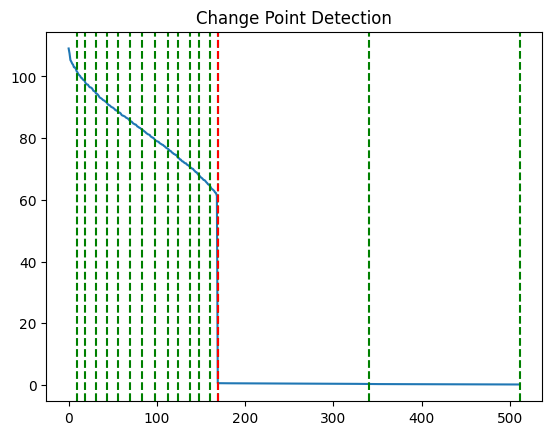

In [ ]:
tensor = generate_tensor(pruning_rate=0.67)
norms = compute_core_norms(tensor).numpy()
# print(norms)
visualize_change_points(norms)

## **Part 1.3: Dataset generation**

Generate a vgg-like model with predefined parameters as below. Compute SV, visualize with/without normalization.

In [ ]:
import numpy as np

def reset_data(N = 13):
  channels = [64, 64, 128, 128, 256, 256, 256, 512, 512, 512, 512, 512, 512,]

  pruning_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.9, 0.1, 0.2, 0.3, 0.4,]

  # Initialize C_in for the first layer
  C_in = 64

  # Initialize a list to store the generated tensors
  vgg_layers = []

  # Loop over the channels and pruning_rates
  for C_out, pruning_rate in zip(channels, pruning_rates):
      # Generate tensor for the current layer
      layer_tensor = generate_tensor(C_out=C_out, C_in=C_in, pruning_rate=pruning_rate)

      # Update C_in for the next layer
      C_in = C_out

      # Append the generated tensor to the list
      vgg_layers.append(layer_tensor)

  # Display the generated tensors
  for i, layer_tensor in enumerate(vgg_layers):
      print(f"Layer {i + 1}: {layer_tensor.shape}")

  # Number of layers
  channels = channels[:N]
  vgg_layers = vgg_layers[:N]
  pruning_rates = pruning_rates[:N]
  singular_values = []
  # Replace this with your actual singular values for each layer
  for i in vgg_layers:
    SV = compute_core_norms(i).numpy()
    singular_values.append(SV)
  # Plotting singular values for each layer
  for i, sv in enumerate(singular_values):
      layer_number = i + 1  # Adjust for 1-based indexing
      plt.plot(sv, label=f'Layer {layer_number}')

  # Adding labels and legend
  plt.xlabel('Number of filters')
  plt.ylabel('Singular Value')
  plt.title(f'Singular Values for N={N} Layers')
  plt.legend()

  # Total number of original channels
  total_original_channels = np.sum(channels)

  # Calculate the absolute number of channels to remove for each layer
  channels_to_remove = [round(pr * ch) for pr, ch in zip(pruning_rates, channels)]

  # Calculate the sum of the absolute number of channels to remove
  total_channels_to_remove = np.sum(channels_to_remove)

  # Calculate the absolute number of channels to keep for each layer
  gt_channels_to_keep = [round((1-pr) * ch) for pr, ch in zip(pruning_rates, channels)]

  total_channels_to_keep = total_original_channels - total_channels_to_remove

  print("Total Original Channels:", total_original_channels)
  print("Total Channels to Remove:", total_channels_to_remove)
  print(f"Total Channels to Keep: {total_channels_to_keep}")

  print(f"Groundtruth channels_to_keep = {gt_channels_to_keep}")

  return singular_values, channels, vgg_layers, total_original_channels, channels_to_remove,  total_channels_to_keep, gt_channels_to_keep


Layer 1: torch.Size([64, 64, 3, 3])
Layer 2: torch.Size([64, 64, 3, 3])
Layer 3: torch.Size([128, 64, 3, 3])
Layer 4: torch.Size([128, 128, 3, 3])
Layer 5: torch.Size([256, 128, 3, 3])
Layer 6: torch.Size([256, 256, 3, 3])
Layer 7: torch.Size([256, 256, 3, 3])
Layer 8: torch.Size([512, 256, 3, 3])
Layer 9: torch.Size([512, 512, 3, 3])
Layer 10: torch.Size([512, 512, 3, 3])
Layer 11: torch.Size([512, 512, 3, 3])
Layer 12: torch.Size([512, 512, 3, 3])
Layer 13: torch.Size([512, 512, 3, 3])
Total Original Channels: 4224
Total Channels to Remove: 1926
Total Channels to Keep: 2298
Groundtruth channels_to_keep = [58, 51, 90, 77, 128, 102, 77, 128, 51, 461, 410, 358, 307]


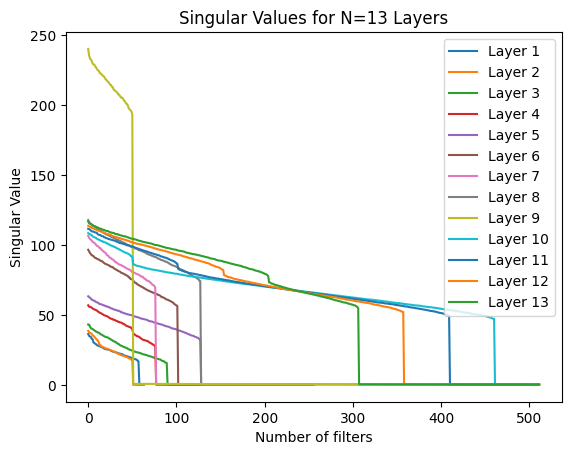

In [ ]:
singular_values, channels, vgg_layers, total_original_channels, channels_to_remove,  total_channels_to_keep, gt_channels_to_keep = reset_data()

# **Part 2: Solve the optimization problem**


## **Part 2.1: Brute-force approach**

Select 4 layers.
Find the rate with brute force approach.

Layer 1: torch.Size([64, 64, 3, 3])
Layer 2: torch.Size([64, 64, 3, 3])
Layer 3: torch.Size([128, 64, 3, 3])
Layer 4: torch.Size([128, 128, 3, 3])
Layer 5: torch.Size([256, 128, 3, 3])
Layer 6: torch.Size([256, 256, 3, 3])
Layer 7: torch.Size([256, 256, 3, 3])
Layer 8: torch.Size([512, 256, 3, 3])
Layer 9: torch.Size([512, 512, 3, 3])
Layer 10: torch.Size([512, 512, 3, 3])
Layer 11: torch.Size([512, 512, 3, 3])
Layer 12: torch.Size([512, 512, 3, 3])
Layer 13: torch.Size([512, 512, 3, 3])
Total Original Channels: 384
Total Channels to Remove: 108
Total Channels to Keep: 276
Groundtruth channels_to_keep = [58, 51, 90, 77]


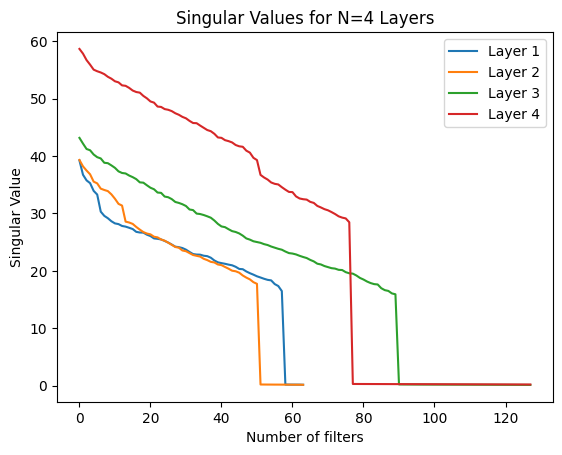

In [ ]:
singular_values, channels, vgg_layers, total_original_channels, channels_to_remove,  total_channels_to_keep, gt_channels_to_keep = reset_data(N = 4)

In [ ]:
from itertools import product
import time

def calculate_objective_value(channels_to_keep, singular_values):
    remaining_singular_values = [sv[:int(ch)] for sv, ch in zip(singular_values, channels_to_keep)]
    return np.sum([np.sum(sv) for sv in remaining_singular_values])

def find_optimal_channels(singular_values, total_channels_to_keep, channels):
    start_time = time.time()

    num_layers = len(channels)
    best_channels_to_keep = None
    best_objective_value = float('-inf')

    # Generate combinations iteratively
    combinations = product(*[range(1, ch + 1) for ch in channels])

    # Filter combinations where the total number of channels to keep is equal to the target
    valid_combinations = (combo for combo in combinations if sum(combo) == total_channels_to_keep)

    # Find the combination with the maximum objective value
    for channels_to_keep in valid_combinations:
        current_objective_value = calculate_objective_value(channels_to_keep, singular_values)
        if current_objective_value > best_objective_value:
            best_objective_value = current_objective_value
            best_channels_to_keep = channels_to_keep

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution Time: {execution_time} seconds")

    return best_channels_to_keep

# Assuming singular_values, total_channels_to_keep, and channels are defined
optimal_channels = find_optimal_channels(singular_values, total_channels_to_keep, channels)
print("Optimal Channels to Keep:", optimal_channels)

Execution Time: 20.007073163986206 seconds
Optimal Channels to Keep: (58, 51, 90, 77)


## **Part 2.3: Change Point Guided Pruning Configuration (CPGPC) Algorithm**

**Algorithm Overview:**

The CPGPC algorithm is designed to efficiently solve the problem of optimal channel selection in neural network layers with a large number of channels. The core idea is to leverage the change points in the singular values of each layer to guide the search for optimal channel configurations.

**Algorithm Steps:**

1. Change Point Detection:
Apply a change point detection algorithm (such as Pelt in the ruptures library) to identify change points in the singular values of each layer.
The detected change points represent points where the behavior of the singular values changes significantly.

2. Search Space Formation ($\mathbf{D}$):
Use the detected change points to form a reduced search space, denoted as $\mathbf{D}$.
$\mathbf{D}$ contains combinations of change points for each layer, providing a more focused exploration space.

3. Iterative Channel Selection:
Iteratively explore combinations of change points in $\mathbf{D}$ to find channel configurations.
Calculate the objective value (sum of singular values) for each combination.
Constraints ensure that the total number of selected channels matches the target.

4. Optimal Channel Configuration:
Track the configuration with the highest objective value during the iterations.
The final selected number of channels to be kept represent the optimal configuration.

**Advantages:**

*Efficiency:* The algorithm significantly reduces the search space by leveraging the insights from change point analysis.

*Guided Exploration:* Change points guide the algorithm towards regions of interest in the singular values, improving the chances of finding optimal configurations.

*Scalability:* Particularly effective for layers with a large number of channels where exhaustive search becomes impractical.

The CPGPC algorithm can be applied to neural network architectures, especially those with deep and complex structures. It balances efficiency and optimality, making it suitable for scenarios where computational resources are constrained.

**Conclusion:**
Change Point Guided Pruning Configuration offers a pragmatic solution to the channel selection problem, demonstrating a balance between computational efficiency and the search for optimal configurations in large neural network layers. The use of change points allows the algorithm to focus on critical regions in the singular values, leading to improved efficiency in practice.

Layer 1: torch.Size([64, 64, 3, 3])
Layer 2: torch.Size([64, 64, 3, 3])
Layer 3: torch.Size([128, 64, 3, 3])
Layer 4: torch.Size([128, 128, 3, 3])
Layer 5: torch.Size([256, 128, 3, 3])
Layer 6: torch.Size([256, 256, 3, 3])
Layer 7: torch.Size([256, 256, 3, 3])
Layer 8: torch.Size([512, 256, 3, 3])
Layer 9: torch.Size([512, 512, 3, 3])
Layer 10: torch.Size([512, 512, 3, 3])
Layer 11: torch.Size([512, 512, 3, 3])
Layer 12: torch.Size([512, 512, 3, 3])
Layer 13: torch.Size([512, 512, 3, 3])
Total Original Channels: 4224
Total Channels to Remove: 1926
Total Channels to Keep: 2298
Groundtruth channels_to_keep = [58, 51, 90, 77, 128, 102, 77, 128, 51, 461, 410, 358, 307]


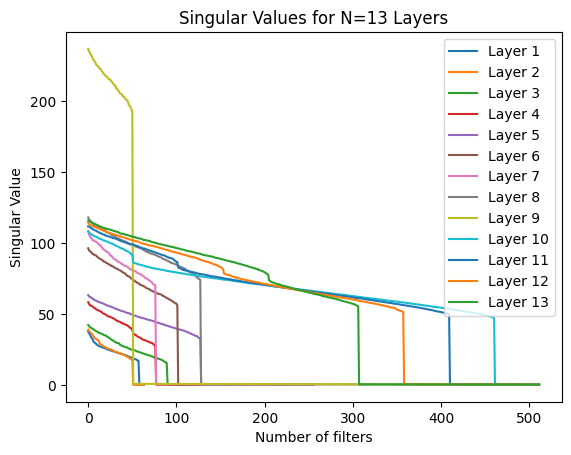

In [ ]:
singular_values, channels, vgg_layers, total_original_channels, channels_to_remove,  total_channels_to_keep, gt_channels_to_keep = reset_data(N = 13)

In [ ]:
import numpy as np
from itertools import product
import time
import ruptures as rpt

def calculate_objective_value(channels_to_keep, change_points_info):
    return np.sum([change_points_info[i][ch] for i, ch in enumerate(channels_to_keep)])


def topk_change_points(signal, k=4):
    """
    Apply change points detection for signal.
    Return top k change points.
    """
    algo = rpt.Pelt(model="l1", jump=1).fit(signal)
    change_points = algo.predict(pen=10)
    change_points = np.array(change_points)
    differences = -np.diff(signal[change_points - 1])
    topk = min(k, len(differences))
    topk_diff_indices = differences.argsort()[-topk:][::-1]

    return change_points[topk_diff_indices]


def detect_change_points(singular_values, k=8):
    """
    Apply change points detection for singular values of each layer.
    Return top k change points and corresponding sum of singular values for each layer.
    """
    change_points = []
    change_points_info = []

    for layer_num, singular_value in enumerate(singular_values, 1):
        points = topk_change_points(singular_value)

        # Compute the sum of singular values at change points
        info = {point: np.sum(singular_value[:point]) for point in points}
        print(
            f"Layer {layer_num}: Detected {len(points)} change points"
            f"at positions {points}, "
            f"with corresponding sums {info}"
        )
        change_points.append(points)
        change_points_info.append(info)

    return change_points, change_points_info


def find_optimal_channels(singular_values, total_channels_to_keep, channels):
    start_time = time.time()

    num_layers = len(channels)
    best_channels_to_keep = None
    best_objective_value = float("-inf")

    # Detect change points
    change_points, change_points_info = detect_change_points(singular_values)

    # Generate combinations iteratively
    combinations = product(*change_points)

    # Find the combination with the maximum objective value
    for channels_to_keep in combinations:
        # Check if the total number of channels to keep is equal to the target
        if sum(channels_to_keep) <= total_channels_to_keep:
            current_objective_value = calculate_objective_value(
                channels_to_keep, change_points_info
            )
            if current_objective_value > best_objective_value:
                best_objective_value = current_objective_value
                best_channels_to_keep = channels_to_keep

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution Time: {execution_time} seconds")

    return best_channels_to_keep, execution_time

# Assuming singular_values, total_channels_to_keep, and channels are defined
optimal_channels, execution_time = find_optimal_channels(singular_values, total_channels_to_keep, channels)
print("Optimal Channels to Keep:", optimal_channels)
assert (optimal_channels == np.array(gt_channels_to_keep)).all(), f"Prediction {optimal_channels} differs from groundtruth {gt_channels_to_keep}"
print("Prediction = Groundtruth, test passed")


Layer 1: Detected 4 change pointsat positions [58  6 46 19], with corresponding sums {58: 1421.8774, 6: 209.44286, 46: 1197.9635, 19: 573.5986}
Layer 2: Detected 4 change pointsat positions [51 13  6 42], with corresponding sums {51: 1343.7914, 13: 451.26566, 6: 223.11368, 42: 1169.5554}
Layer 3: Detected 4 change pointsat positions [90 75 12 25], with corresponding sums {90: 2474.4294, 75: 2206.2424, 12: 474.99097, 25: 933.1029}
Layer 4: Detected 4 change pointsat positions [77 51 62 42], with corresponding sums {77: 3290.5574, 51: 2458.7615, 62: 2837.087, 42: 2088.925}
Layer 5: Detected 4 change pointsat positions [128 115   7  20], with corresponding sums {128: 6058.576, 115: 5606.065, 7: 432.93607, 20: 1192.8779}
Layer 6: Detected 4 change pointsat positions [102  10  59  30], with corresponding sums {102: 7666.4233, 10: 932.5775, 59: 4908.5156, 30: 2666.7349}
Layer 7: Detected 4 change pointsat positions [77 15 25  5], with corresponding sums {77: 6690.8013, 15: 1531.8783, 25: 248

For a more extensive set of experiments involving varying values of $N$, please refer to: https://api.wandb.ai/links/pvtien96/ohqncmar

## **Part 2.2: Optimization outils**

This part tries multiple available optimization toolboxs (Scipy, cvxpy).

### **Part 2.2.2: Test cvxpy**

In [ ]:
import cvxpy as cp

# Objective function
def objective(channels_to_keep):
    remaining_singular_values = [cp.slice(sv, (0, 0), (len(sv), int(ch))) for sv, ch in zip(singular_values, channels_to_keep)]
    return cp.sum([cp.sum(sv) for sv in remaining_singular_values])

# Define the variable
x = cp.Variable(len(singular_values), integer=True)

# # Objective
# objective_value = cp.Maximize(cp.sum(cp.hstack([cp.sum(sv[:cp.round(ch)]) for sv, ch in zip(singular_values, x.value)])))

def calculate_objective_value(x, singular_values):
    # Check if x.value is not None
    if x.value is not None:
        # Calculate the objective value using x.value
        rounded_values = [int(round(ch)) for ch in x.value]
        remaining_singular_values = [sv[:rv] for sv, rv in zip(singular_values, x.value)]
        return np.sum([np.sum(sv) for sv in remaining_singular_values])
    else:
        # Handle the case where x.value is None (e.g., infeasible problem)
        return -np.inf  # You can choose any appropriate value here

# Example usage
objective_value = cp.Maximize(calculate_objective_value(x, singular_values))

# Constraints
constraints = [cp.sum(x) == total_channels_to_keep]

# Problem
problem = cp.Problem(objective_value, constraints)

# Solve the problem
result = problem.solve()

# Optimal channels to keep
optimal_channels_to_keep = x.value.astype(int)
print("Optimal Channels to Keep:", optimal_channels_to_keep)

print("Status: ", problem.status)
print("The optimal value is", problem.value)

**Conclusion**: I'm stucking here.

### **Conclusion**:
The efficacy of Scipy's optimization is significantly dependent on the initialization. In my testing, it seems inefficient, potentially because of the broad search space. It's worth mentioning that the normalization of the singular values doesn't impact the result (confirmed through testing).

# **Section C: CHANNEL SELECTION**

To date, our investigations have primarily focused on determining the optimal configuration for retaining a specific number of channels. However, an equally crucial facet of channel pruning involves addressing the question of "Which channels to keep?" Our initial hypothesis posits that the multidimensional singular values inherently signify the informational content, and the objective of channel pruning is to retain the most pivotal channels, thereby maximizing the singular values post-pruning. Consequently, singular values can serve as a criterion for defining which filters to retain or discard.

Given our precise knowledge of the desired number of channels to retain, an initial approach involves a systematic trial-and-error methodology (or greedy method). Specifically, for each removal of a channel from the weight tensor, we calculate the singular values and quantify the difference relative to the original singular values. This difference can be construed as the contribution of the corresponding filter to the layer. Aggregating these contributions from all filters provides a measure of their saliency, guiding the channel pruning process effectively.

---
To be continued...


